In [55]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1D Stochastic Heat Transfer ODE
### $\frac{\partial T(t)}{\partial{t}} = F(t) + \lambda T(t) + \sqrt{K}\xi(t)$,
where $T(t)$ is the temperature, $F(t)$ is the effective radiative forcing, $\lambda$ is the feedback parameter, $K$ is related to the diffusivity of the system, and $\xi(t)$ is the noise.


In [143]:
# Grid parameters
dt = 1
Nt = 250 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
lam = 0.85
K = 0.1

# Forcing parameters
F_2xCO2 = response_utils.F_const(t, 3.7)

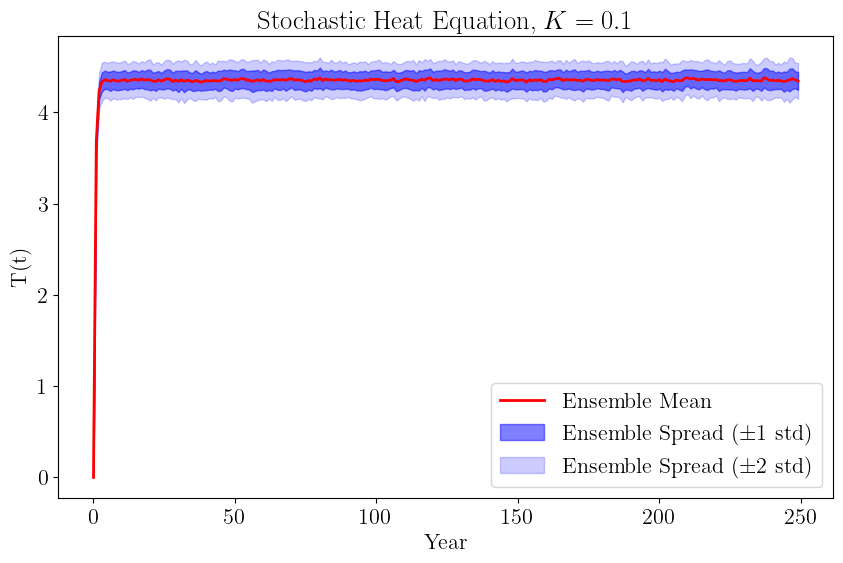

In [144]:
N_ensemble = 100

# Initialize arrays for temperature T and noise xi
T_2xCO2 = np.zeros((N_ensemble, len(t)))
T_2xCO2[:,0] = 0
xi = np.random.normal(0, 1, (N_ensemble, len(t)))  # Gaussian white noise

# Perform numerical integration using Euler-Maruyama method
for i in range(1, len(t)):
    T_2xCO2[:,i] = T_2xCO2[:,i-1] + (-lam * T_2xCO2[:,i-1] + F_2xCO2[i-1] + K * xi[:,i-1]) * dt

# Compute ensemble mean
T_2xCO2_mean = np.mean(T_2xCO2, axis=0)
T_2xCO2_std = np.std(T_2xCO2, axis=0)
plt.figure(figsize=(10, 6))

# Plot ensemble mean
plt.plot(t, T_2xCO2_mean, color='red', label='Ensemble Mean', linewidth=2)
plt.fill_between(t, T_2xCO2_mean - T_2xCO2_std, T_2xCO2_mean + T_2xCO2_std, color='blue', alpha=0.5, label='Ensemble Spread (±1 std)')
plt.fill_between(t, T_2xCO2_mean - 2*T_2xCO2_std, T_2xCO2_mean + 2*T_2xCO2_std, color='blue', alpha=0.2, label='Ensemble Spread (±2 std)')
plt.xlabel('Year')
plt.ylabel('T(t)')
plt.title(f'Stochastic Heat Equation, $K = {K}$')
plt.legend()
plt.show()

	L2 Error, Mean: 0.16893


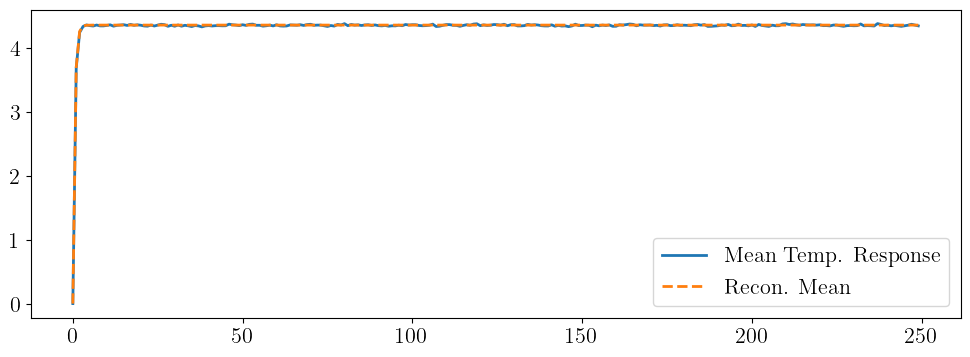

In [145]:
g_2xCO2_mean, a_2xCO2_mean = response_utils.calc_modes_1D(T_2xCO2_mean, t)

T_vec = [T_2xCO2_mean]
F_vec = [F_2xCO2]

# Calculate L
L_raw_2xCO2 = response_utils.calc_L_direct_1D(T_2xCO2[1,:], F_2xCO2, t)
L_modal_2xCO2 = response_utils.calc_L_direct_1D(a_2xCO2_mean, F_2xCO2, t, modal=True, g=g_2xCO2_mean)

L2_mean = plot_response_1D(T_2xCO2, F_2xCO2, t, L_raw_2xCO2, T0=0, dt=1)
print(f'\tL2 Error, Mean: {np.round(L2_mean, 5)}')
#labels = ['2xCO2']
#T_est_raw = response_utils.plot_response_1D(T_vec, F_vec, labels, t, L_raw_2xCO2, L_raw_2xCO2, T0=0, dt=1)

In [146]:
from numpy import linalg

def plot_response_1D(T, F, t, L_raw, T0, dt):
  T_mean = np.mean(T, axis=0)

  colors = ['b','r','m','g']
  fig, ax = plt.subplots()
  T_est_mean = response_utils.reconstruct_T(F, t, L_raw, T0, dt)

  ax.plot(t, T_mean, lw=2, label='Mean Temp. Response')
  ax.plot(t, T_est_mean, ls='--', lw=2, label=f'Recon. Mean')
  ax.legend()

  L2_mean = linalg.norm(T_mean - T_est_mean)

  return L2_mean

In [147]:
def calc_L2(T_vec, T_est, labels, mode):
  L2 = np.zeros(len(T_vec) + 1)
  print(f'Error from {mode} estimation.')
  for i in range(len(T_vec)):
    L2[i] = linalg.norm(T_vec[i] - T_est[i])
    print(f'\tL2 Error, {labels[i]}: {np.round(L2[i], 5)}')

  L2[-1] = np.mean(L2[:-1])
  print(f'Avg. L2 Error: {np.round(L2[-1], 5)}\n')
  return L2

In [148]:
dT_dt = response_utils.calc_derivative(np.reshape(T_2xCO2_mean, (1, len(T_2xCO2_mean))), t)
dT_dt_j = response_utils.calc_derivative(T_2xCO2, t)
stoch = dT_dt_j - dT_dt

In [149]:
def plot_response_stoch_1D(T, stoch, F, t, L_raw, T0, dt):
  T_mean = np.mean(T, axis=0)

  colors = ['b','r','m','g']
  T_est_mean = response_utils.reconstruct_T(F, t, L_raw, T0, dt)
  T_est_stoch = stoch + T_est_mean
  T_std = np.std(T, axis=0)
  T_est_std = np.std(T_est_stoch, axis=0)

  L2_mean = linalg.norm(T_mean - T_est_mean)
  L2_std = linalg.norm(T_std - T_est_std)

  plt.figure(figsize=(10, 6))
  plt.plot(t, T_mean, color='k', label='True Ensemble Mean', linewidth=2)
  plt.plot(t, T_est_mean, color='r', ls='--', label='Est. Ensemble Mean', linewidth=2)
  plt.fill_between(t, T_est_mean - T_est_std, T_est_mean + T_est_std, color='b', alpha=0.5, label='Est. Ensemble Spread (±1 std)')
  plt.fill_between(t, T_est_mean - 2*T_est_std, T_est_mean + 2*T_est_std, color='b', alpha=0.2, label='Est. Ensemble Spread (±2 std)')
  plt.xlabel('Year')
  plt.ylabel('T(t)')
  plt.title(f'Stochastic Heat Equation, $K = {K}$')
  plt.legend()
  plt.show()

  return L2_mean, L2_std

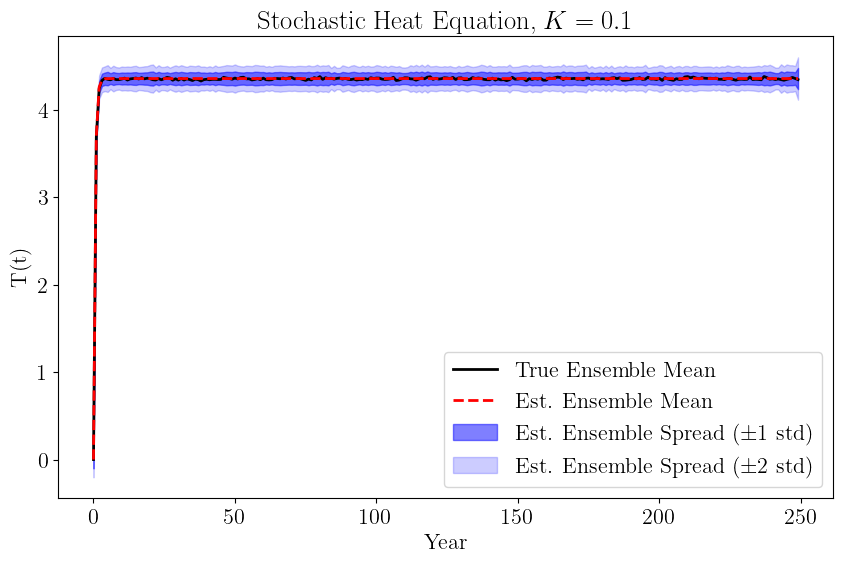

0.16893105803004824
0.5067058991270501


In [150]:
L2_mean_2xCO2, L2_std_2xCO2 = plot_response_stoch_1D(T_2xCO2, stoch, F_2xCO2, t, L_raw_2xCO2, T0=0, dt=1)
print(L2_mean_2xCO2),
print(L2_std_2xCO2)

In [1]:
stoch

NameError: name 'stoch' is not defined

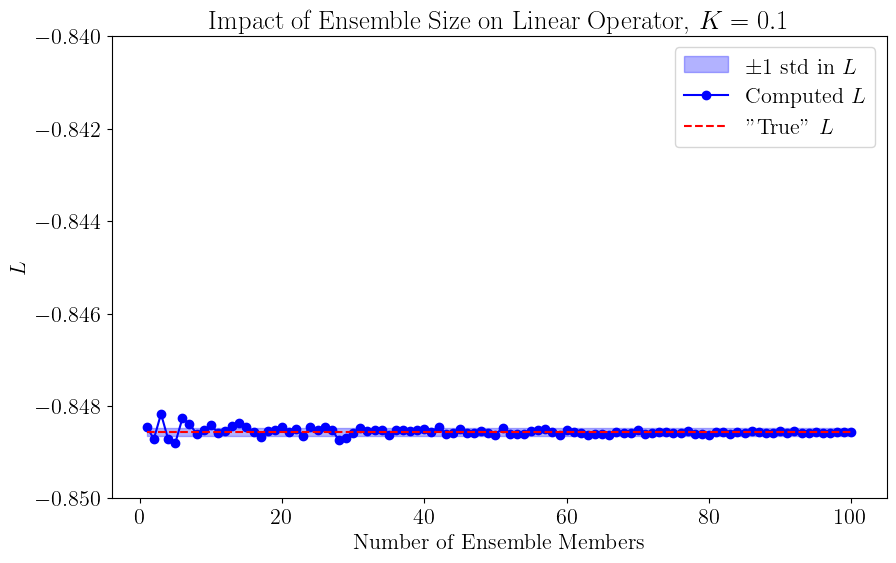

In [85]:
# Parameters
n_trials = 10      # Number of times to sample for each n

# Create a list to store the L values for each sample size
L_values = []

# Loop over different number of ensemble members to sample
for n in range(1, N_ensemble + 1):
    L_samples = []

    # Perform n_trials random samplings for each n
    for _ in range(n_trials):
        # Randomly sample n ensemble members without replacement
        sampled_indices = np.random.choice(N_ensemble, size=n, replace=False)
        T_sample_mean = np.mean(T_2xCO2[sampled_indices, :], axis=0)

        # Compute L for the sampled mean and store it
        L_samples.append(response_utils.calc_L_direct_1D(T_sample_mean, F_2xCO2, t))

    # Take the average L for this sample size
    L_values.append(np.mean(L_samples))

L_std = np.std(L_values, axis=0)

# Plot L vs. the number of ensemble members
plt.figure(figsize=(10, 6))
plt.fill_between(range(1, N_ensemble + 1), L_values[-1]*np.ones(N_ensemble) - L_std, L_values[-1]*np.ones(N_ensemble) + L_std, color='blue', alpha=0.3, label='±1 std in $L$')
plt.plot(range(1, N_ensemble + 1), L_values, marker='o', linestyle='-', color='blue', label='Computed $L$')
plt.plot(range(1, N_ensemble + 1), L_values[-1]*np.ones(N_ensemble), linestyle='--', color='red', label='"True" $L$')
plt.ylim(-0.850,-0.840)
plt.xlabel('Number of Ensemble Members')
plt.ylabel('$L$')
plt.title(f'Impact of Ensemble Size on Linear Operator, $K = {K}$')
plt.legend()
plt.show()
